# Setup - Requires a docker container yuh
```bash
sudo docker run --device=nvidia.com/gpu=all \
                                                      -p 51000:51000 \
                                                      --shm-size 2g \
                                                      -e CLIP_MODEL_NAME=jinaai/jina-clip-v2 \
                                                      -v ~/.cache/huggingface:/root/.cache/huggingface \
                                                      jinaai/clip-server:latest
                                                      
```

In [37]:
import nest_asyncio
nest_asyncio.apply()
import os
import glob
import io
from PIL import Image, UnidentifiedImageError
from docarray import Document, DocumentArray
from clip_client import Client

# Using the IP found in your server logs
c = Client('grpc://172.17.0.8:51000') 

c.profile()

Roundtrip  5ms  100% 
├──  Client-server network  3ms  58% 
└──  Server  2ms  42% 
    ├──  Gateway-CLIP network  0ms  0% 
    └──  CLIP model  2ms  100%

{'Roundtrip': 4.730897999252193,
 'Client-server network': 2.7308979992521927,
 'Server': 2,
 'Gateway-CLIP network': 0,
 'CLIP model': 2}

In [25]:
import os
import glob
from docarray import Document, DocumentArray
# 2. Find all images in the directory
image_dir = os.path.expanduser('~/workspace/Datasets/Pictures/')
# Add any other extensions you have (e.g., .png, .jpeg)
image_paths = glob.glob(os.path.join(image_dir, '*')) 

# Filter to ensure we only try to open images
valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.webp'}
image_paths = [p for p in image_paths if os.path.splitext(p)[1].lower() in valid_extensions]

print(f"Found {len(image_paths)} images in {image_dir}")


Found 1556 images in /home/jovyan/workspace/Datasets/Pictures/


In [38]:
docs = DocumentArray([Document(uri=path) for path in image_paths])

def data_generator(docs):
    for doc in docs:
        try:
            # 1. Load the file bytes into the Document
            doc.load_uri_to_blob() 
            
            # 2. Validate the image integrity locally before sending
            # This catches corrupt files before they crash the server
            with Image.open(io.BytesIO(doc.blob)) as img:
                img.verify() 
            
            # 3. If valid, yield the document
            yield doc
            
        except (UnidentifiedImageError, OSError, Exception) as e:
            # Print the specific file that is causing the crash
            print(f"Skipping corrupt file: {doc.uri} | Error: {e}")

In [39]:
print(f"Sending {len(docs)} images to CLIP server...")

# batch_size=16 is a safe number to prevent timeouts or OOM on the GPU
embeddings = c.encode(
    data_generator(docs), 
    batch_size=16, 
    show_progress=True
)

print(f"Finished! Embeddings Shape: {embeddings.embeddings.shape}")

Output()

Sending 1556 images to CLIP server...


Skipping corrupt file: /home/jovyan/workspace/Datasets/Pictures/9gabf750zmg71.gif | Error: cannot identify image 
file <_io.BytesIO object at 0x7f4176596430>

Finished! Embeddings Shape: (1555, 512)


Encoding 5 control images...

QUERY: 1761545212565880.jpg
Debug Data (Top Matches):
[ { 'filename': 'people-tree-photoshoot-autumn-winter-2010-v0-t3sc4z11fzxf1.webp',
    'score': np.float32(0.2553),
    'uri': '/home/jovyan/workspace/Datasets/Pictures/people-tree-photoshoot-autumn-winter-2010-v0-t3sc4z11fzxf1.webp'},
  { 'filename': '11349024_002_c9cd.jpg',
    'score': np.float32(0.265),
    'uri': '/home/jovyan/workspace/Datasets/Pictures/11349024_002_c9cd.jpg'},
  { 'filename': '1762265071900593.jpg',
    'score': np.float32(0.2745),
    'uri': '/home/jovyan/workspace/Datasets/Pictures/1762265071900593.jpg'},
  { 'filename': '1762204339340031.png',
    'score': np.float32(0.2759),
    'uri': '/home/jovyan/workspace/Datasets/Pictures/1762204339340031.png'},
  { 'filename': '11349024_001_8915.jpg',
    'score': np.float32(0.2806),
    'uri': '/home/jovyan/workspace/Datasets/Pictures/11349024_001_8915.jpg'}]


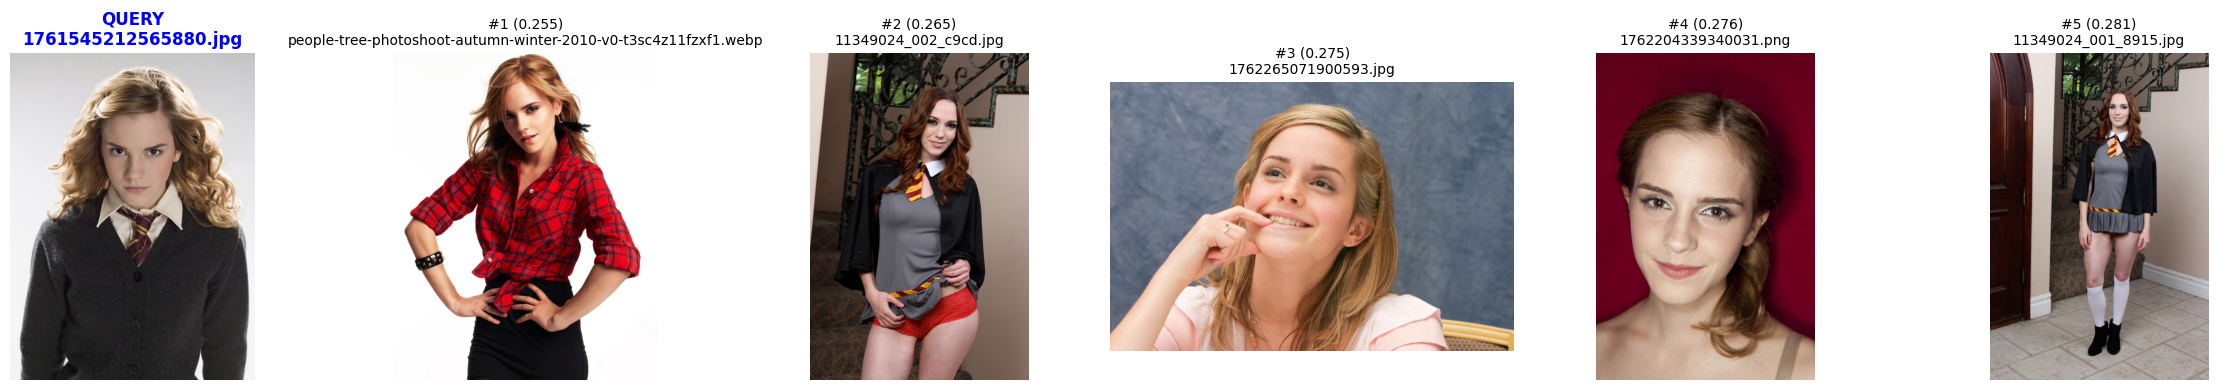


QUERY: 471187088_10161415512427606_5252195410000689832_n.jpg
Debug Data (Top Matches):
[ { 'filename': 'triangl-poppy-mashmallow-yellow1.jpg',
    'score': np.float32(0.1161),
    'uri': '/home/jovyan/workspace/Datasets/Pictures/triangl-poppy-mashmallow-yellow1.jpg'},
  { 'filename': 'farrah-wild-thing-2.jpg',
    'score': np.float32(0.1224),
    'uri': '/home/jovyan/workspace/Datasets/Pictures/farrah-wild-thing-2.jpg'},
  { 'filename': '5e263275d16aaa094c97bbd5fbd6d186.jpeg',
    'score': np.float32(0.1254),
    'uri': '/home/jovyan/workspace/Datasets/Pictures/5e263275d16aaa094c97bbd5fbd6d186.jpeg'},
  { 'filename': 'bambi-sugar-plum-web.jpg',
    'score': np.float32(0.1448),
    'uri': '/home/jovyan/workspace/Datasets/Pictures/bambi-sugar-plum-web.jpg'},
  { 'filename': 'tumblr_npu24euCMM1txqdrdo1_640.jpg',
    'score': np.float32(0.1473),
    'uri': '/home/jovyan/workspace/Datasets/Pictures/tumblr_npu24euCMM1txqdrdo1_640.jpg'}]


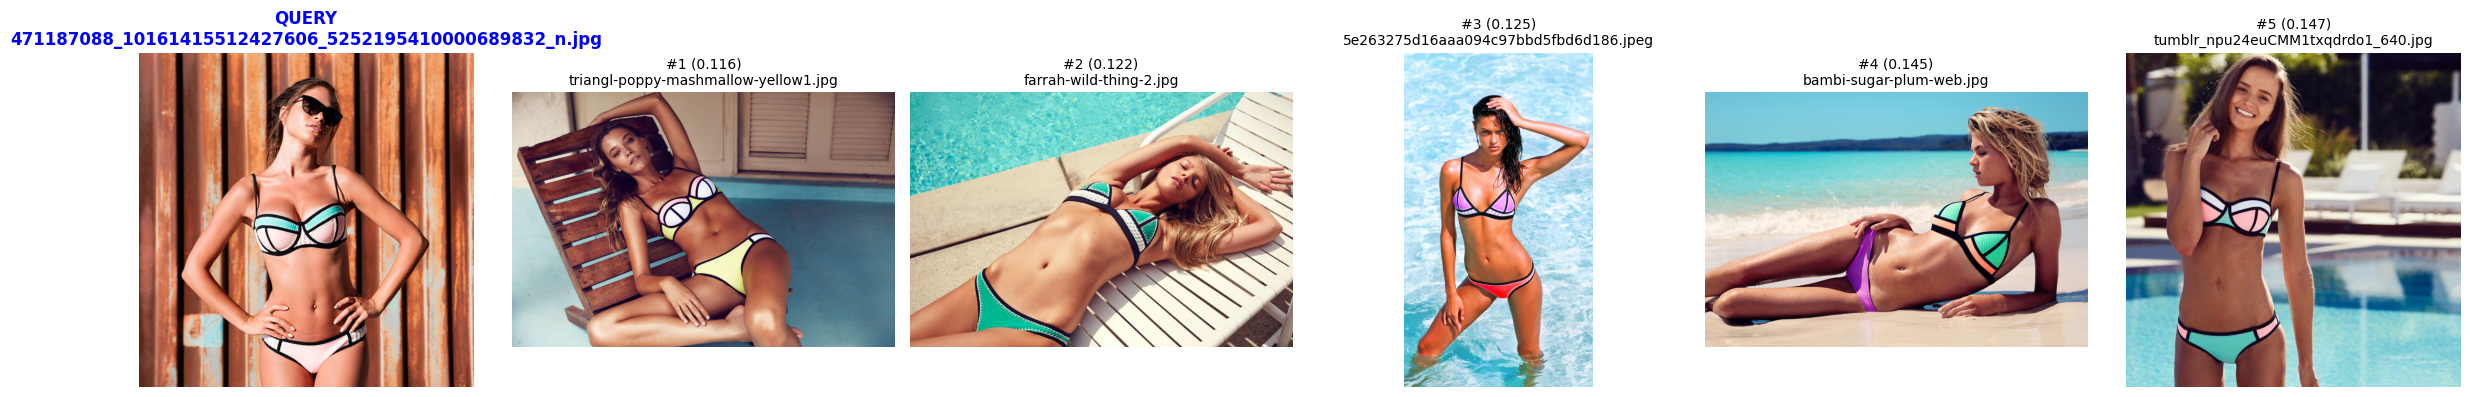


QUERY: 1763571919384294.jpg
Debug Data (Top Matches):
[ { 'filename': '25w4dtoi6wyf1.jpeg',
    'score': np.float32(0.1643),
    'uri': '/home/jovyan/workspace/Datasets/Pictures/25w4dtoi6wyf1.jpeg'},
  { 'filename': 'little-ari-random-pics-v0-m29qu9nzxh1g1.webp',
    'score': np.float32(0.2049),
    'uri': '/home/jovyan/workspace/Datasets/Pictures/little-ari-random-pics-v0-m29qu9nzxh1g1.webp'},
  { 'filename': 'little-ari-random-pics-v0-lcoqb9nzxh1g1.webp',
    'score': np.float32(0.2282),
    'uri': '/home/jovyan/workspace/Datasets/Pictures/little-ari-random-pics-v0-lcoqb9nzxh1g1.webp'},
  { 'filename': 'little-ari-random-pics-v0-tr5ecbnzxh1g1.webp',
    'score': np.float32(0.2367),
    'uri': '/home/jovyan/workspace/Datasets/Pictures/little-ari-random-pics-v0-tr5ecbnzxh1g1.webp'},
  { 'filename': 'little-ari-random-pics-v0-tds94anzxh1g1.webp',
    'score': np.float32(0.252),
    'uri': '/home/jovyan/workspace/Datasets/Pictures/little-ari-random-pics-v0-tds94anzxh1g1.webp'}]


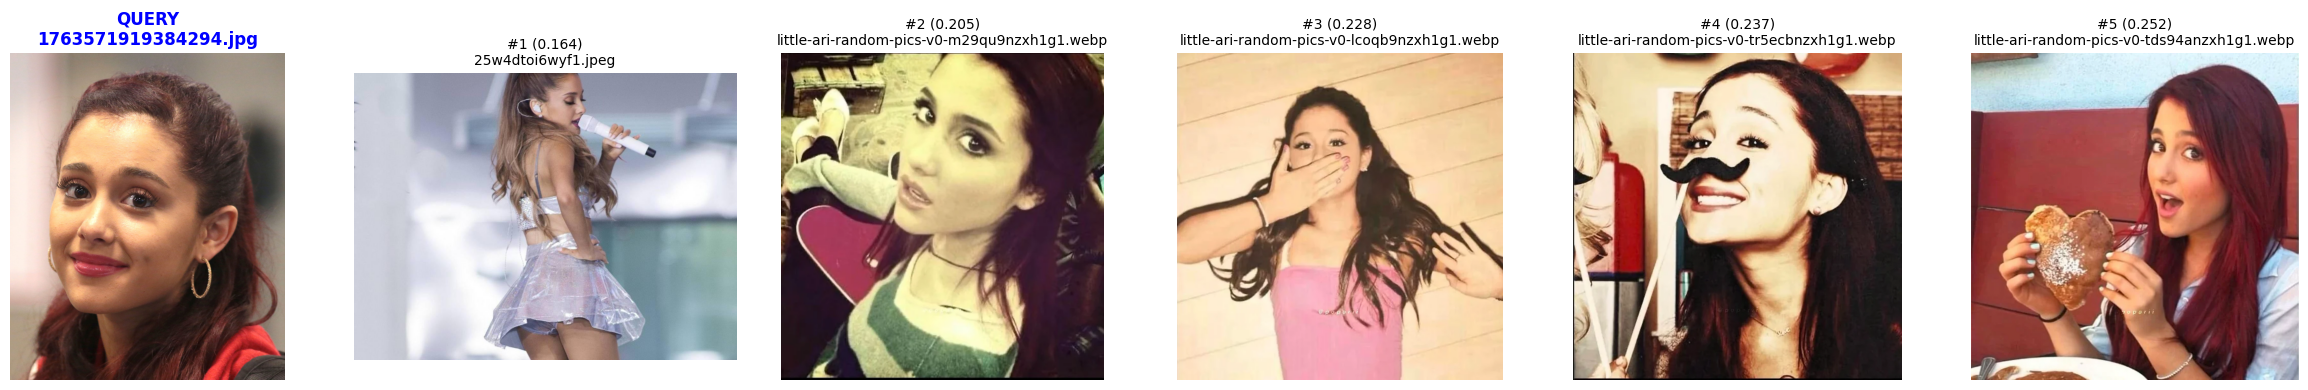


QUERY: Screenshot 2024-03-02 14-02-26.png
Debug Data (Top Matches):
[ { 'filename': 'Screenshot 2024-03-02 14-02-29.png',
    'score': np.float32(0.1164),
    'uri': '/home/jovyan/workspace/Datasets/Pictures/Screenshot '
           '2024-03-02 14-02-29.png'},
  { 'filename': 'Screenshot 2024-03-16 17-33-28.png',
    'score': np.float32(0.1369),
    'uri': '/home/jovyan/workspace/Datasets/Pictures/Screenshot '
           '2024-03-16 17-33-28.png'},
  { 'filename': 'Screenshot 2024-03-16 17-34-09.png',
    'score': np.float32(0.1703),
    'uri': '/home/jovyan/workspace/Datasets/Pictures/Screenshot '
           '2024-03-16 17-34-09.png'},
  { 'filename': 'Screenshot 2024-03-16 17-34-06.png',
    'score': np.float32(0.1842),
    'uri': '/home/jovyan/workspace/Datasets/Pictures/Screenshot '
           '2024-03-16 17-34-06.png'},
  { 'filename': 'Screenshot 2024-03-16 18-02-59.png',
    'score': np.float32(0.1893),
    'uri': '/home/jovyan/workspace/Datasets/Pictures/Screenshot '
          

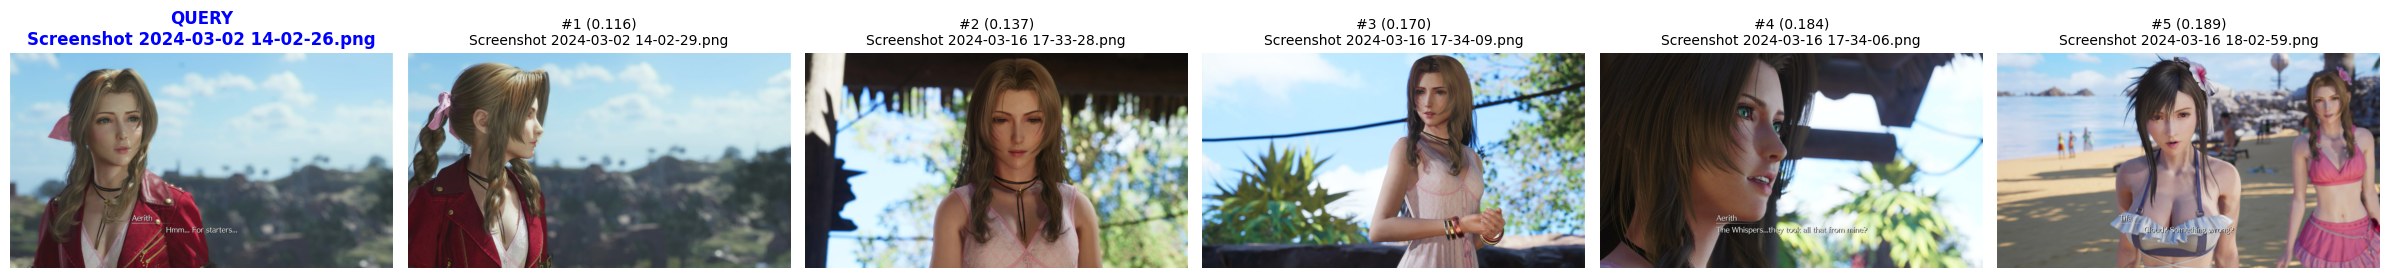


QUERY: 2008-taylor-swift-tour-v0-whcs3m73r31g1.webp
Debug Data (Top Matches):
[ { 'filename': '2008-taylor-swift-tour-v0-345u2a23r31g1.webp',
    'score': np.float32(0.1434),
    'uri': '/home/jovyan/workspace/Datasets/Pictures/2008-taylor-swift-tour-v0-345u2a23r31g1.webp'},
  { 'filename': 'if-taylor-full-stepped-into-the-acting-scene-what-genres-do-v0-ipkggpf2abpc1.webp',
    'score': np.float32(0.1838),
    'uri': '/home/jovyan/workspace/Datasets/Pictures/if-taylor-full-stepped-into-the-acting-scene-what-genres-do-v0-ipkggpf2abpc1.webp'},
  { 'filename': 'wxnohjgwa1a71.webp',
    'score': np.float32(0.1986),
    'uri': '/home/jovyan/workspace/Datasets/Pictures/wxnohjgwa1a71.webp'},
  { 'filename': 'ooooold-songs-v0-go43n08jkxqc1.webp',
    'score': np.float32(0.2154),
    'uri': '/home/jovyan/workspace/Datasets/Pictures/ooooold-songs-v0-go43n08jkxqc1.webp'},
  { 'filename': 'taylors-award-show-performance-outfits-through-the-years-v0-6au8emsbzn1g1.webp',
    'score': np.float32(0.2

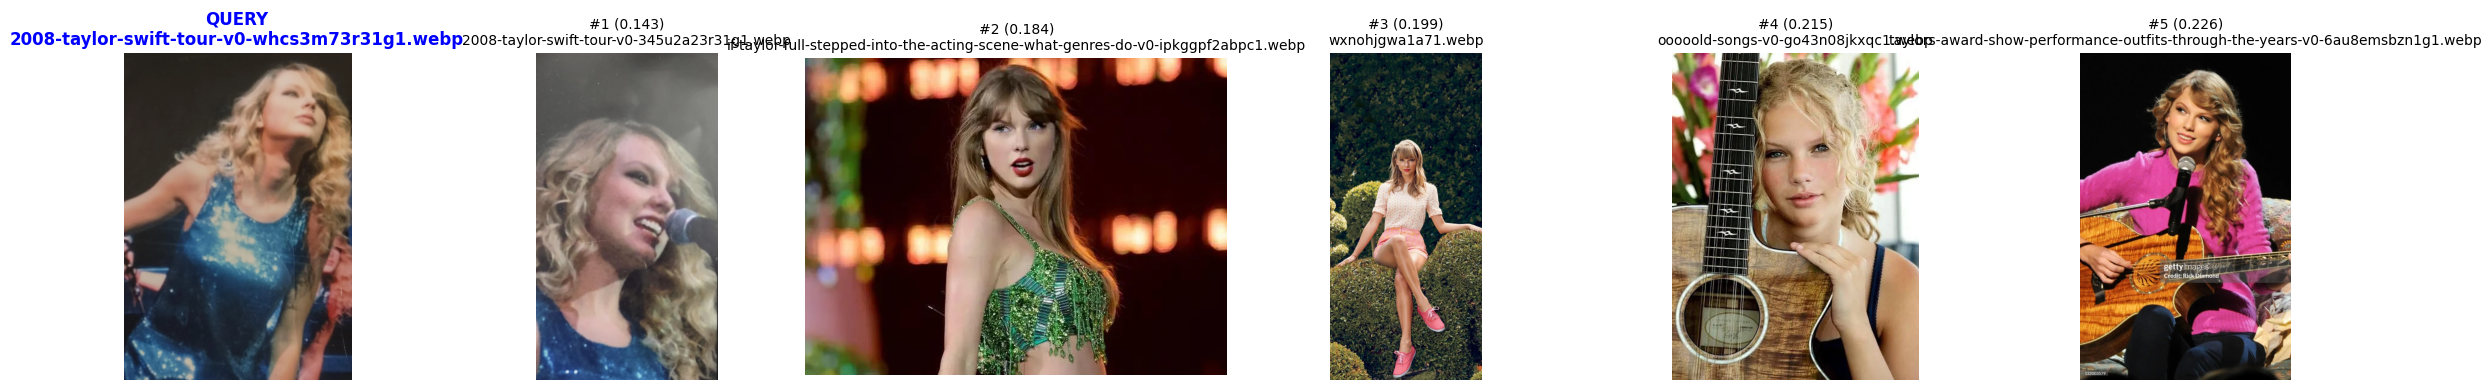

In [41]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from docarray import Document, DocumentArray
import pprint

# --- Configuration ---
# Set how many matches you want to see (excluding the self-match)
TOP_K = 5 

# 1. Load and Encode Control Images
control_dir = os.path.expanduser('~/workspace/Datasets/Pictures/Control/')
control_files = [f for f in os.listdir(control_dir) if not f.startswith('.')]
control_docs = DocumentArray([
    Document(uri=os.path.join(control_dir, f)) for f in control_files
])

# Load blobs for encoding
for d in control_docs:
    d.load_uri_to_blob()

print(f"Encoding {len(control_docs)} control images...")
control_encoded = c.encode(control_docs)

# 2. Match against the main dataset
# We ask for TOP_K + 1 because we expect the first match to be the image itself
control_encoded.match(embeddings, limit=TOP_K + 1)

# 3. Pretty Print & Visualize
for query_doc in control_encoded:
    query_name = os.path.basename(query_doc.uri)
    
    # --- Filter out "Self" matches ---
    # We keep matches only if the score is somewhat less than 1.0 (e.g. < 0.9999)
    # OR if the filename is different.
    real_matches = []
    for m in query_doc.matches:
        match_name = os.path.basename(m.uri)
        # Check if it's effectively the same image
        if match_name != query_name and m.scores['cosine'].value < 0.99999:
            real_matches.append(m)
    
    # Trim to the number of results we actually want
    real_matches = real_matches[:TOP_K]

    # --- Text Output (Debug Data) ---
    print(f"\n{'='*60}")
    print(f"QUERY: {query_name}")
    print(f"{'='*60}")
    
    debug_data = []
    for m in real_matches:
        debug_data.append({
            "score": round(m.scores['cosine'].value, 4),
            "filename": os.path.basename(m.uri),
            "uri": m.uri
        })
    
    print("Debug Data (Top Matches):")
    pprint.pprint(debug_data, indent=2, width=60)

    # --- Visual Output (Matplotlib) ---
    # Create a figure: 1 row, (1 query + N matches) columns
    cols = len(real_matches) + 1
    fig, axes = plt.subplots(1, cols, figsize=(4 * cols, 4))
    
    # 1. Plot Query Image
    if cols == 1: axes = [axes] # Handle edge case if single plot
    
    try:
        img_query = mpimg.imread(query_doc.uri)
        axes[0].imshow(img_query)
        axes[0].set_title(f"QUERY\n{query_name}", color='blue', fontsize=12, fontweight='bold')
        axes[0].axis('off')
    except Exception as e:
        axes[0].text(0.5, 0.5, f"Image Error\n{e}", ha='center')

    # 2. Plot Result Images
    for i, match in enumerate(real_matches):
        ax = axes[i+1]
        try:
            img_match = mpimg.imread(match.uri)
            ax.imshow(img_match)
            score = match.scores['cosine'].value
            fname = os.path.basename(match.uri)
            
            # Green title for high similarity, black for lower
            color = 'green' if score > 0.85 else 'black'
            ax.set_title(f"#{i+1} ({score:.3f})\n{fname}", color=color, fontsize=10)
            ax.axis('off')
        except Exception as e:
            ax.text(0.5, 0.5, "Image Error", ha='center')
            
    plt.tight_layout()
    plt.show()